In [4]:
cd ..

/Users/dani/Google Drive/Uni/Master/P4 2021/DD2424 - Deep Learning for Data Science/Project/ScarceClassifier


In [168]:
from src.d04_mixmatch.wideresnet import WideResNet
from src.d02_data.load_data import get_dataloaders_validation
from src.d03_processing.transform_data import AddGaussianNoise
from src.d07_visualization.visualize_cifar10 import show_img
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import time

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


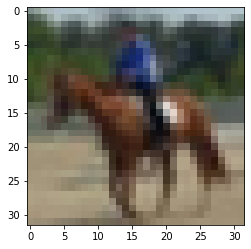

In [236]:
# Get data
train_loader, val_loader, test_loader = get_dataloaders_validation(path='data', 
                                                                   batch_size=4, train_size=1000, val_size=0)
show_img(iter(train_loader).next()[0][0])

In [237]:
# Init model
model = WideResNet(depth=28, k=2, n_out=10)


In [238]:
class Augment:
    def __init__(self, K=2):
        self.K = K
        self.transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
                                            AddGaussianNoise(mean=0, std=0.15)])

    def __call__(self, batch):
        augmented_batch = torch.zeros((self.K, batch.shape[0], batch.shape[1], batch.shape[2], batch.shape[3]))
        for k in range(self.K):
            augmented_batch[k] = self.transform(batch)
        return augmented_batch

In [317]:
class MixMatch(object):

    def __init__(self, model, T=0.5, K=2, alpha=0.75):
        self.T = T
        self.K = K
        self.alpha = alpha
        self.softmax = nn.Softmax(dim=1)
        self.model = model
        self.n_labels = 10 # Warning! hardcoded

    def run(self, x_imgs, x_labels, u_imgs):
        # One hot encoding
        x_labels = self.one_hot_encoding(x_labels)
        print(x_labels.shape)
        # Augment
        augment_once = Augment(K=1)
        augment_k = Augment(K=self.K)
        
        start_aug = time.time()
        x_hat = augment_once(x_imgs)
        u_hat = augment_k(u_imgs)
        print('Augment time: %.4f' % (time.time() - start_aug))

        # Generate guessed labels
        start_lbl = time.time()
        q_bar = self.guess_label(u_hat)
        print('Label time: %.4f' % (time.time() - start_lbl))

        start_sharpen = time.time()
        q = self.sharpen(q_bar)
        print('Sharpen time: %.4f' % (time.time() - start_sharpen))

        x_hat = x_hat.reshape((-1, 3, 32, 32))
        u_hat = u_hat.reshape((-1, 3, 32, 32))
        q = q.repeat(2,1,1).reshape(-1, 10)
        w_img = torch.cat((x_hat, u_hat))
        w_label = torch.cat((x_labels, q))
        
        return q, w_img, w_label
    
    
    def sharpen(self, q_bar):
        q_bar = q_bar.numpy()
        q = np.power(q_bar, 1/self.T) / np.sum(np.power(q_bar, 1/self.T), axis=1)[:, np.newaxis]
        return torch.from_numpy(q)
    
    def guess_label(self, u_hat):
        n_batch = u_hat.shape[1]
        
        self.model.eval()
        with torch.no_grad():
            q_bar = torch.zeros([n_batch, self.n_labels])
            for k in range(self.K):
                q_bar += self.softmax(self.model(u_hat[k]))
            q_bar /= self.K
            
        self.model.train()
        return q_bar

    def one_hot_encoding(self, labels):
        shape = (labels.shape[0], self.n_labels)
        one_hot = np.zeros(shape)
        rows = np.arange(labels.shape[0])
        one_hot[rows, labels] = 1
        return torch.from_numpy(one_hot)
    

In [318]:
x_imgs, x_labels = iter(train_loader).next()
u_imgs, _ = iter(train_loader).next()

mixmatch = MixMatch(model)

start = time.time()
q, w_img, w_label = mixmatch.run(x_imgs, x_labels, u_imgs)
print('Total time: %.4f' % (time.time() - start))


torch.Size([4, 10])
Augment time: 0.0037
Label time: 0.0939
Sharpen time: 0.0012
torch.Size([4, 10])
torch.Size([8, 10])
Total time: 0.1002


In [122]:
 torch.sum(torch.pow(q_bar, 2), axis=1).shape
    

torch.Size([64])

In [50]:
x_hat.shape

torch.Size([1, 64, 3, 32, 32])

In [125]:
u_hat.requires_grad


False